In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [10]:
def downSample(rawOutData):
## downsample
    time = 100e-6
    freq = 2.4e9
    sampleRate = 8e6
    dt = 1/sampleRate
    rawLen = rawOutData.shape[0]
    txLen = int(time/dt)
    downSampleRate = int(rawLen / (txLen))

    processedOut = []
    for i in range(int(txLen)+1):
        if i*downSampleRate<rawLen:
            processedOut.append(rawOutData[i*downSampleRate])
    processedOut=np.array(processedOut[:-1])
    print("rawLen:", rawLen)
    print("txLen:", txLen)
    print("downSampleRate", downSampleRate)
    return processedOut

In [8]:
def loadRawHarmonics(filePath, stype="OUT", save=False): #stype => "time", "OUT", "inputBBSignal"
    ## Load signal from .raw file
    ## Save signal in (2, 800) npy
    f=open(filePath, 'r')
    lines=f.readlines()
    record = False

    time = "time"
    out = "OUT"
    input = "inputBBSignal"

    harmonic = filePath.split("/")[-1].split(".")[1]
    timeSeries=[]
    inSig=[]
    outSig=[]

    for line in lines:
        if line == "END\n":
            # print("Finish loading one .envlp!")
            break

        if not record:
            if line == "VALUE\n":
                record = True
        else:
            label, value = line.split(" ", maxsplit=1)[0], line.split(" ", maxsplit=1)[1]
            # print("label: ", label)
            # print("value: ", value)
            if label == "\""+stype+"\"":
                if stype == time:
                    timeSeries.append(float(value))
                else:
                    real = float(value.split(" ")[0][1:])
                    imag = float(value.split(" ")[1][:-2]) # last "\n"
                    # print("real: ", real)
                    # print("imag: ", imag)
                    if stype == out:
                        outSig.append([real, imag])
                    elif stype == input:
                        inSig.append([real, imag])
                    else: 
                        print("Stype Error!")
                        break

    inSig =  np.array(inSig)
    outSig = np.array(outSig)
    timeSeries = np.array(timeSeries)
    # print("raw input shape: ", inSig.shape)
    print("raw out shape: ", outSig.shape)
    plt.plot(outSig[:, 0])
    plt.plot(outSig[:, 1])
    
    if stype == time:
        if save:
            savedSig = "G:/My Drive/sim20H/processedData/"+"TimeSeries.npy"
            np.save(savedSig, timeSeries.T)
        return timeSeries
    elif stype == out:
        outSigDownsapled = downSample(outSig)
        outSigDownsapled = outSigDownsapled.T # (2, 800)
        if save:
            savedOutSig = "G:/My Drive/sim20H/processedData/"+"H"+harmonic+".npy"
            np.save(savedOutSig, outSigDownsapled)
        return outSigDownsapled
    elif stype == input:
        inSigDownsapled = downSample(inSig)
        inSigDownsapled = inSigDownsapled.T
        if save:
            savedInSig = "G:/My Drive/CMU/Research/RFF-RL/sim20H/inSignal.npy"
            np.save(savedInSig, inSigDownsapled)   
        return inSigDownsapled

raw out shape:  (240002, 2)
rawLen: 240002
txLen: 800
downSampleRate 300
down-sampled harmonic:  (2, 800)
raw out shape:  (240002, 2)
rawLen: 240002
txLen: 800
downSampleRate 300
down-sampled harmonic:  (2, 800)
raw out shape:  (240002, 2)
rawLen: 240002
txLen: 800
downSampleRate 300
down-sampled harmonic:  (2, 800)


KeyboardInterrupt: 

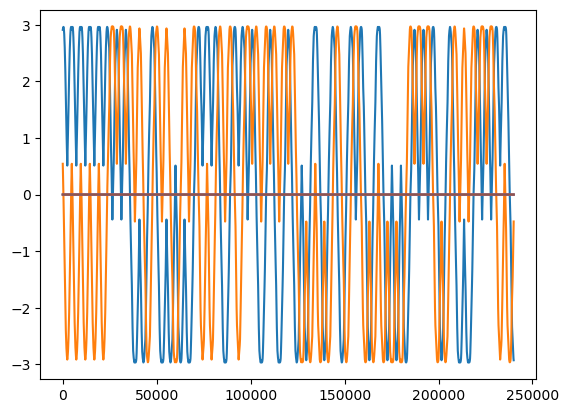

In [11]:
PATH = "../sim20H/sim20H_sample1/"

fs = 8e6
N_features=6 # {[config]: [power(dB), fftoffset, freqoffset, fftangleoffset, angleoffset, thd(20)]}

files = os.listdir(PATH)
N_harmonics = 20

for file in files[:5]:
    if len(file.split("_"))>1 and len(file.split("."))<2 and int(file.split("_")[2][5:])==1:
        cfg = int(file.split("_")[1][6:])
        filePath = PATH+file+"/"+file+".raw/"
        # Load harmonic output from .envlp, H1~H20
        envlps = os.listdir(filePath)
        
        harmonics=np.zeros(N_harmonics)
        harmonicsdB=np.zeros(N_harmonics)
        for envlp in envlps:
            if len(envlp.split(".")) == 4 and envlp.split(".")[-1] == "envlp" and 0<int(envlp.split(".")[1])<=20:
                idx = int(envlp.split(".")[1])
                envlpPath = filePath+envlp
                # print("envlppath: ", envlpPath)
                harmonic=loadRawHarmonics(envlpPath, save=False) # set save=False (2, 800)
                print("down-sampled harmonic: ", harmonic.shape)
  

thd:  0.0160576363724628
harmonics power:  [7.04082016e+03 1.80454310e+00 1.08050512e-02 1.04085427e-04
 6.03734944e-06 8.06207248e-07 9.07329670e-08 1.38730216e-08
 1.47891553e-09 7.44457031e-10 8.31798565e-11 4.82891919e-11
 1.75629628e-11 9.85047106e-12 1.92827879e-12 2.16156853e-12
 1.07753424e-13 1.83627328e-13 3.50576093e-14 7.11317785e-14]


Text(0.5, 1.0, 'Harmonics Power')

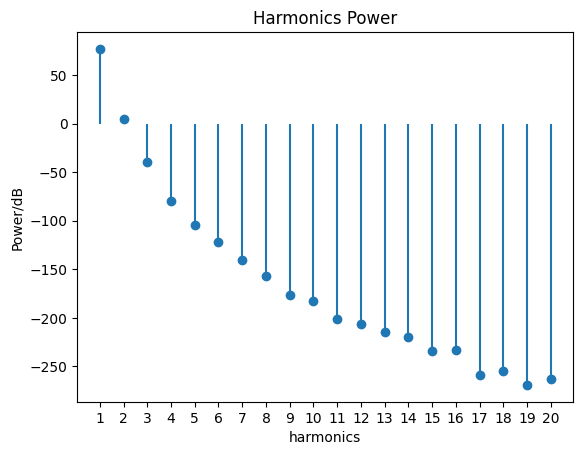

In [78]:
import os
import matplotlib.pyplot as plt
PATH = "G:/My Drive/sim20H/processedData/"
files = os.listdir(PATH)
N_harmonics = 20
harmonics=np.zeros(N_harmonics)
harmonicsdB=np.zeros(N_harmonics)

for file in files:
    
    if file[0]=="H":
        idx = file.split(".")[0][1:]
        harmonic = np.load("G:/My Drive/sim20H/processedData/"+"H"+idx+".npy")
        power = np.sum(harmonic[:,0]**2+harmonic[:,1]**2)
        powerdB = 20*np.log10(power) #dB
        harmonics[int(idx)-1] = power
        harmonicsdB[int(idx)-1] = powerdB

thd = np.sqrt(np.sum(harmonics[1:])/harmonics[0])
print("thd: ", thd)
print("harmonics power: ", harmonics)

harmonics_idx = np.arange(1,21)

# plt.plot(harmonics_idx, harmonics)
plt.xticks(harmonics_idx)
plt.vlines(harmonics_idx, np.zeros(N_harmonics), harmonicsdB)
plt.scatter(harmonics_idx, harmonicsdB)
plt.xlabel("harmonics")
plt.ylabel("Power/dB")
plt.title("Harmonics Power")

In [31]:
PATH = "G:/My Drive/CMU/Research/RFF-RL/sim20H/sim20H_sample13/"
cfgs = np.load("G:/My Drive/CMU/Research/RFF-RL/sim/rawData/configs.npy")
preamble = np.load("G:/My Drive/CMU/Research/RFF-RL/sim20H/inSignal.npy")

fs = 8e6
N_features=6 # {[config]: [power(dB), fftoffset, freqoffset, fftangleoffset, angleoffset, thd(20)]}

N = preamble.shape[0] # (2, 800)
preamble = preamble[0]+1j*preamble[1]
preamblepower = np.sqrt(np.sum(np.real(preamble)**2+np.imag(preamble)**2))
preamblepower = 20*np.log10(preamblepower) #dB
print("preamble power: ", preamblepower)

preamblefft = np.abs(np.fft.fftshift(np.fft.fft(preamble)))
preamblefftangle = np.angle(np.fft.fftshift(np.fft.fft(preamble)))
preambleangle=np.angle(preamble)
preamblefreq = fs*(np.argmax(preamblefft)+1)/N

cfgset={}
for cfg in cfgs:
    # cfgset[tuple(cfg)]=[[] for _ in range(N_features)] # to calculate avg value
    cfgset[tuple(cfg)]=[]

files = os.listdir(PATH)
N_harmonics = 20

for file in files:
    if len(file.split("_"))>1 and len(file.split("."))<2 and int(file.split("_")[2][5:])==1:
        cfg = int(file.split("_")[1][6:])
        # if cfg>1:
        #      break
        print("Start loading cfg {}...".format(cfg))
        cfg = tuple(cfgs[cfg-1])
        filePath = PATH+file+"/"+file+".raw/"
        # Load harmonic output from .envlp, H1~H20
        envlps = os.listdir(filePath)
        
        harmonics=np.zeros(N_harmonics)
        harmonicsdB=np.zeros(N_harmonics)
        for envlp in envlps:
            if len(envlp.split(".")) == 4 and envlp.split(".")[-1] == "envlp" and 0<int(envlp.split(".")[1])<=20:
                idx = int(envlp.split(".")[1])
                envlpPath = filePath+envlp
                # print("envlppath: ", envlpPath)
                harmonic=loadRawHarmonics(envlpPath) # set save=False (2, 800)
                # print("harmonic: ", harmonic.shape)
                # plt.plot(np.real(preamble))
                # plt.plot(harmonic[0,:])
                # plt.show()
                # plt.plot(np.imag(preamble))
                # plt.plot(harmonic[1,:])
                # plt.show()
                power = np.sum(harmonic[0]**2+harmonic[1]**2)
                powerdB = 10*np.log10(power) #dB
                harmonics[idx-1] = power
                harmonicsdB[idx-1] = powerdB
                if idx == 1:
                    # Calculate fft features
                    cfgset[cfg].append(powerdB)

                    compsig = harmonic[0]+1j*harmonic[1]
                    compsigNorm = compsig/np.mean(np.abs(compsig))
                    fft = np.abs(np.fft.fftshift(np.fft.fft(compsigNorm)))
                    fftangle = np.angle(np.fft.fftshift(np.fft.fft(compsigNorm)))
                    sigangle = np.angle(compsigNorm).reshape(-1,1)
                    freq = fs*(np.argmax(fft)+1)/N
                    
                    # plt.plot(fft)
                    # plt.plot(preamblefft)
                    # plt.title("fft")
                    # plt.show()

                    # plt.plot(fftangle)
                    # plt.plot(preamblefftangle)
                    # plt.title("fftangle")
                    # plt.show()

                    # plt.plot(sigangle)
                    # plt.plot(preambleangle)
                    # plt.title("angle")
                    # plt.show()
                    
                    fftoffset = np.mean(fft-preamblefft)
                    freqoffset = freq - preamblefreq
                    fftangleoffset = np.mean(fftangle - preamblefftangle)
                    angleoffset= np.mean(sigangle-preambleangle)

                    # print("fftoffset: ", fftoffset)
                    # print("freqoffset: ", freqoffset)
                    # print("fftangleoffset: ", fftangleoffset)
                    # print("angleoffset: ", angleoffset)
                    # print("\n")

                    cfgset[cfg].append(fftoffset)
                    cfgset[cfg].append(freqoffset)
                    cfgset[cfg].append(fftangleoffset)
                    cfgset[cfg].append(angleoffset)
        thd = np.sqrt(np.sum(harmonics[1:])/harmonics[0])
        # print("thd: ", thd)
        # print("\n")
        cfgset[cfg].append(thd)
        print(cfgset[cfg])
        print("\n")

np.save("G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/cfgset20HFFt_sample13.npy", cfgset)
print(cfgset[tuple(cfgs[10])])
print(cfgset[tuple(cfgs[110-2])])
print(cfgset[tuple(cfgs[45])])

preamble power:  29.011037416351787
Start loading cfg 64...
[38.476041778627284, 0.02175686442973661, 0.0, 0.11555005217549329, 0.02021621213407894, 0.016056045846472657]


Start loading cfg 66...
[38.47611095874441, 0.02171773618458125, 0.0, 0.11562942476886284, 0.020212691011808705, 0.016055899968086484]


Start loading cfg 67...
[38.47614184231166, 0.02178609638042379, 0.0, 0.11541550550552593, 0.020200104286890664, 0.016055912387560312]


Start loading cfg 1...
[38.4762282083113, 0.022046568325610486, 0.0, 0.11576339291660691, 0.020253810578862594, 0.01605637051975855]


Start loading cfg 2...
[38.47611115894544, 0.02176378227224383, 0.0, 0.11554178830500654, 0.020205866739790777, 0.01605599887081189]


Start loading cfg 3...
[38.47606666701288, 0.021801257520311697, 0.0, 0.11546484574476427, 0.020183659260907354, 0.016055758609116885]


Start loading cfg 4...
[38.47631351274856, 0.021869585759191176, 0.0, 0.11636487168832137, 0.020276070422157778, 0.01605694981259342]


Start load

In [142]:
cfgset1 = np.load("G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData_sample1/cfgset20HFFt_sample1.npy", allow_pickle=True)
key, val = list(cfgset1.item().keys()), list(cfgset1.item().values())
print(key[0:3])
print(val[0:3])

[(0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1), (0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1), (0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1)]
[[38.47623251645038, 0.021688609866675437, 0.0, 0.11610328871695814, 0.020397353348784997, 0.0160576363724628], [38.47610966562907, 0.021795235751099904, 0.0, 0.11593173878392779, 0.020407740830421604, 0.01605776323516239], [38.47596174808488, 0.021931411354249235, 0.0, 0.11547519395282635, 0.020348339010574222, 0.01605678183627644]]


Text(0.5, 1.0, 'Harmonics Power')

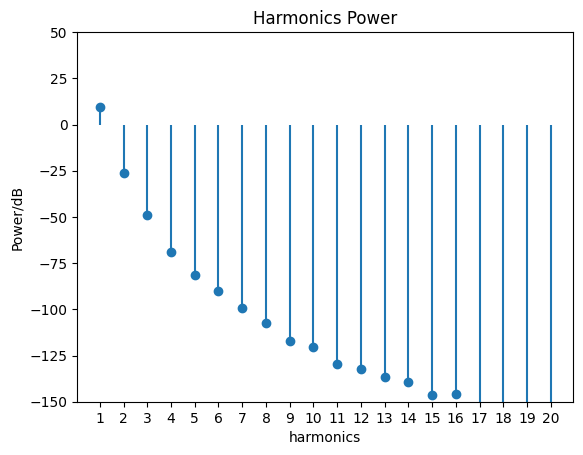

In [14]:
harmonics_idx = np.arange(1,21)

# plt.plot(harmonics_idx, harmonics)
plt.xticks(harmonics_idx)
plt.vlines(harmonics_idx, np.zeros(N_harmonics), harmonicsdB)
plt.scatter(harmonics_idx, harmonicsdB)
plt.ylim([-150, 50])
plt.xlabel("harmonics")
plt.ylabel("Power/dB")
plt.title("Harmonics Power")

In [30]:
PATH = "G:/My Drive/CMU/Research/RFF-RL/sim20H/sim20H_sample1718/"
cfgs = np.load("G:/My Drive/CMU/Research/RFF-RL/sim/rawData/configs.npy")

#dataset20H={"outSignals":np.array(220, 20, 2, 800), "labels":np.array(220, 12)},
outSignals=[]
labels = []
dataset20H={}

files = os.listdir(PATH)

for file in files:
    if len(file.split("_"))>1 and len(file.split("."))<2 and int(file.split("_")[2][5:])==2:
        cfg = int(file.split("_")[1][6:])
        # if cfg!=80:
        #      continue
        print("Start loading cfg {}...".format(cfg))
        labels.append(cfgs[cfg-1])
        filePath = PATH+file+"/"+file+".raw/"
        # Load harmonic output from .envlp, H1~H20
        envlps = os.listdir(filePath)
        harmonics_tmp = np.zeros((20, 2, 800))

        for envlp in envlps:
            if len(envlp.split(".")) == 4 and envlp.split(".")[-1] == "envlp" and 0<int(envlp.split(".")[1])<=20:
                idx = int(envlp.split(".")[1])-1
                envlpPath = filePath+envlp
                print("envlp: ", envlp)
                harmonic=loadRawHarmonics(envlpPath) # set save=False, (2, 800)
                harmonics_tmp[idx] = harmonic
                # print("harmonic: ", harmonic.shape)
                # plt.plot(np.real(preamble))
                # plt.plot(harmonic[0,:])
                # plt.plot(np.imag(preamble))
                # plt.plot(harmonic[1,:])
                # plt.show()
        outSignals.append(harmonics_tmp)

outSignals =np.array(outSignals)
labels = np.array(labels)
print("outSignals shape: ", outSignals.shape)
print("labels shape: ", labels.shape)

dataset20H["outSignals"]=outSignals
dataset20H["labels"]=labels

np.save("G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/dataset/dataset20H_sample18.npy", dataset20H)

Start loading cfg 1...
envlp:  envlp.1.fd.envlp
envlp:  envlp.2.fd.envlp
envlp:  envlp.3.fd.envlp
envlp:  envlp.4.fd.envlp
envlp:  envlp.5.fd.envlp
envlp:  envlp.6.fd.envlp
envlp:  envlp.7.fd.envlp
envlp:  envlp.8.fd.envlp
envlp:  envlp.9.fd.envlp
envlp:  envlp.10.fd.envlp
envlp:  envlp.11.fd.envlp
envlp:  envlp.12.fd.envlp
envlp:  envlp.13.fd.envlp
envlp:  envlp.14.fd.envlp
envlp:  envlp.15.fd.envlp
envlp:  envlp.16.fd.envlp
envlp:  envlp.17.fd.envlp
envlp:  envlp.18.fd.envlp
envlp:  envlp.19.fd.envlp
envlp:  envlp.20.fd.envlp
Start loading cfg 2...
envlp:  envlp.1.fd.envlp
envlp:  envlp.2.fd.envlp
envlp:  envlp.3.fd.envlp
envlp:  envlp.4.fd.envlp
envlp:  envlp.5.fd.envlp
envlp:  envlp.6.fd.envlp
envlp:  envlp.7.fd.envlp
envlp:  envlp.8.fd.envlp
envlp:  envlp.9.fd.envlp
envlp:  envlp.10.fd.envlp
envlp:  envlp.11.fd.envlp
envlp:  envlp.12.fd.envlp
envlp:  envlp.13.fd.envlp
envlp:  envlp.14.fd.envlp
envlp:  envlp.15.fd.envlp
envlp:  envlp.16.fd.envlp
envlp:  envlp.17.fd.envlp
envlp:  en

In [105]:
# Add single config result
dic=np.load("G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/dataset/dataset20H_sample5.npy", allow_pickle=True)
datasets, targets = dic.item().get("outSignals"), dic.item().get("labels")

print(datasets[124])

filePath = "G:/My Drive/CMU/Research/RFF-RL/sim20H/sim20H_sample11/sim20H_Config125_Width1_Length1/sim20H_Config125_Width1_Length1.raw/"
envlps = os.listdir(filePath)
harmonics_tmp = np.zeros((20, 2, 800))

for envlp in envlps:
    if len(envlp.split(".")) == 4 and envlp.split(".")[-1] == "envlp" and 0<int(envlp.split(".")[1])<=20:
        idx = int(envlp.split(".")[1])-1
        envlpPath = filePath+envlp
        print("envlp: ", envlp)
        harmonic=loadRawHarmonics(envlpPath) # set save=False, (2, 800)
        print("harmonic: ", harmonic)
        harmonics_tmp[idx] = harmonic

datasets[124] = harmonics_tmp
print("dataset20H125:", datasets[124])

dataset20H={}
dataset20H["outSignals"]=datasets[:]
dataset20H["labels"]=targets

np.save("G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/dataset/dataset20H_sample5_new.npy", dataset20H)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
envlp:  envlp.1.fd.envlp
harmonic:  [[ 2.91161   2.95897   2.92214  ... -2.30982  -2.542    -2.78669 ]
 [ 0.545636  0.107987 -0.498679 ... -1.86979  -1.54167  -1.02963 ]]
envlp:  envlp.2.fd.envlp
harmonic:  [[ 0.044623    0.0379029   0.0230848  ...  0.0383985   0.0446018
   0.0476032 ]
 [-0.0160534  -0.0284068  -0.04131    ...  0.0281123   0.0168925
  -0.00087071]]
envlp:  envlp.3.fd.envlp
harmonic:  [[-0.00284869 -0.00155821  0.00066295 ...  0.0025772   0.00341329
   0.00361299]
 [ 0.0023273   0.0033239   0.00357658 ...  0.00259831  0.00137744
  -0.0006851 ]]
envlp:  envlp.4.fd.envlp
harmonic:  [[ 2.39556e-04  4.79489e-05 -2.28485e-04 ...  1.59264e-04  3.08497e

In [96]:
## Avg time series signal
sigma = 1 
samples=[1,2,3,4,7,9,10]
n_samples = len(samples)

datasets_avg={}
for sample in samples:
    dic=np.load("G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/dataset/dataset20H_sample"+str(sample)+".npy", allow_pickle=True)
    datasets, targets = dic.item()["outSignals"], dic.item()["labels"]
    for i in range(targets.shape[0]):
        cfg=tuple(targets[i])
        if cfg in datasets_avg.keys():
            datasets_avg[cfg].append(datasets[i])
        else:
            datasets_avg[cfg]=[datasets[i]]

targets=[]
datasets=[]
for cfg in datasets_avg.keys():
    targets.append(np.array(cfg))
    if len(datasets_avg[cfg]) !=7:
        print("Wrong!")
        print("cfg: ", cfg)
        print("len: ", len(datasets_avg[cfg]))
    datasets.append(sum(datasets_avg[cfg])/len(datasets_avg[cfg]))

dataset20H_avg={}
dataset20H_avg["outSignals"]=np.array(datasets)
dataset20H_avg["labels"]=np.array(targets)

np.save("G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/dataset/dataset20H_avg_sigma1.npy", dataset20H)

In [99]:
## cfgset for avg time series data
PATH = "G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/dataset/"
savePATH = "G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/cfgset/"
cfgs = np.load("G:/My Drive/CMU/Research/RFF-RL/sim/rawData/configs.npy")
preamble = np.load("G:/My Drive/CMU/Research/RFF-RL/sim20H/inSignal.npy")
samples=np.arange(1, 12)


fs = 8e6
# N_features=6 # {[config]: [power(dB), fftoffset, freqoffset, fftangleoffset, angleoffset, thd(20)]}

N = preamble.shape[0] # (2, 800)
preamble = preamble[0]+1j*preamble[1]
preamblepower = np.sqrt(np.sum(np.real(preamble)**2+np.imag(preamble)**2))
preamblepower = 20*np.log10(preamblepower) #dB
print("preamble power: ", preamblepower)

preamblefft = np.abs(np.fft.fftshift(np.fft.fft(preamble)))
preamblefftangle = np.angle(np.fft.fftshift(np.fft.fft(preamble)))
preambleangle=np.angle(preamble)
preamblefreq = fs*(np.argmax(preamblefft)+1)/N

N_harmonics = 20

cfgset={}
for cfg in cfgs:
# cfgset[tuple(cfg)]=[[] for _ in range(N_features)] # to calculate avg value
    cfgset[tuple(cfg)]=[]

savedatasetName = "cfgset20HFFt_correctPower_sample" + str(sample)
dic=np.load("G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/dataset/dataset20H_avg_sigma1.npy", allow_pickle=True)
datasets, targets = dic.item().get("outSignals"), dic.item().get("labels")

for cfg_idx in range(datasets.shape[0]):
# for cfg_idx in range(1):
    cfg = tuple(cfgs[cfg_idx])
    harmonics=np.zeros(N_harmonics)
    harmonicsdB=np.zeros(N_harmonics)
    for h_idx in range(N_harmonics):
        harmonic = datasets[cfg_idx][h_idx]
            
        power = np.sum(harmonic[0]**2+harmonic[1]**2)/len(harmonic[0])
        powerdB = 10*np.log10(power) #dB
        harmonics[h_idx] = power
        harmonicsdB[h_idx] = powerdB
        if h_idx == 0:
            # Calculate fft features
            cfgset[cfg].append(powerdB)

            compsig = harmonic[0]+1j*harmonic[1]
            compsigNorm = compsig/np.mean(np.abs(compsig))
            fft = np.abs(np.fft.fftshift(np.fft.fft(compsigNorm)))
            fftangle = np.angle(np.fft.fftshift(np.fft.fft(compsigNorm)))
            sigangle = np.angle(compsigNorm).reshape(-1,1)
            freq = fs*(np.argmax(fft)+1)/N
            
            fftoffset = np.mean(fft-preamblefft)
            freqoffset = freq - preamblefreq
            fftangleoffset = np.mean(fftangle - preamblefftangle)
            angleoffset= np.mean(sigangle-preambleangle)

            cfgset[cfg].append(fftoffset)
            cfgset[cfg].append(freqoffset)
            cfgset[cfg].append(fftangleoffset)
            cfgset[cfg].append(angleoffset)
    thd = np.sqrt(np.sum(harmonics[1:])/harmonics[0])

    # Add sinad to orginal cfgset
    thd = np.sqrt(np.sum(harmonics[1:])/harmonics[0])
    sinad = np.sqrt(harmonics[0]/np.sum(harmonics[1:]))
    thd = 20*np.log10(thd)
    sinad = 20*np.log10(sinad)
    

    cfgset[cfg].append(thd)
    cfgset[cfg].append(sinad)
    
print(cfgset[tuple(cfgs[10])])
print(cfgset[tuple(cfgs[110-2])])
print(cfgset[tuple(cfgs[45])])

np.save("G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/cfgset/cfgset20HFFtAvgOfIQ_sigma1.npy", cfgset)

preamble power:  29.011037416351787
[9.444399740876472, 0.021725560822030768, 0.0, 0.11651446023867237, 0.021029694436032916, -35.884049121620805, 35.884049121620805]
[9.44452363167181, 0.021970373784789676, 0.0, 0.1164592384755878, 0.021059334985024703, -35.88371895209091, 35.88371895209091]
[9.444462360992642, 0.021890139666971196, 0.0, 0.11647081010794474, 0.02101712868562791, -35.88407196831639, 35.88407196831639]


In [108]:
PATH = "G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/dataset/"
savePATH = "G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/cfgset/"
cfgs = np.load("G:/My Drive/CMU/Research/RFF-RL/sim/rawData/configs.npy")
preamble = np.load("G:/My Drive/CMU/Research/RFF-RL/sim20H/inSignal.npy")
samples=np.arange(5, 6)


fs = 8e6
# N_features=6 # {[config]: [power(dB), fftoffset, freqoffset, fftangleoffset, angleoffset, thd(20)]}

N = preamble.shape[0] # (2, 800)
preamble = preamble[0]+1j*preamble[1]
preamblepower = np.sqrt(np.sum(np.real(preamble)**2+np.imag(preamble)**2))
preamblepower = 20*np.log10(preamblepower) #dB
print("preamble power: ", preamblepower)

preamblefft = np.abs(np.fft.fftshift(np.fft.fft(preamble)))
preamblefftangle = np.angle(np.fft.fftshift(np.fft.fft(preamble)))
preambleangle=np.angle(preamble)
preamblefreq = fs*(np.argmax(preamblefft)+1)/N

N_harmonics = 20

for sample in samples:
    cfgset={}
    for cfg in cfgs:
    # cfgset[tuple(cfg)]=[[] for _ in range(N_features)] # to calculate avg value
        cfgset[tuple(cfg)]=[]

    datasetName = "dataset20H_sample"+str(sample)
    savedatasetName = "cfgset20HFFt_correctPower_sample" + str(sample)
    dic=np.load(PATH+datasetName+".npy", allow_pickle=True)
    datasets, targets = dic.item().get("outSignals"), dic.item().get("labels")
    for cfg_idx in range(datasets.shape[0]):
    # for cfg_idx in range(1):
        cfg = tuple(cfgs[cfg_idx])
        harmonics=np.zeros(N_harmonics)
        harmonicsdB=np.zeros(N_harmonics)
        for h_idx in range(N_harmonics):
            harmonic = datasets[cfg_idx][h_idx]
                
            # print("harmonic: ", harmonic.shape)
            # plt.plot(np.real(preamble))
            # plt.plot(harmonic[0,:])
            # plt.show()
            # plt.plot(np.imag(preamble))
            # plt.plot(harmonic[1,:])
            # plt.show()
            power = np.sum(harmonic[0]**2+harmonic[1]**2)/len(harmonic[0])
            if power == 0:
                print("sample_idx: ", sample)
                print("cfg_idx: ", cfg_idx)
                print("h_idx: ", h_idx)
                print("\n")
                
            powerdB = 10*np.log10(power) #dB
            harmonics[h_idx] = power
            harmonicsdB[h_idx] = powerdB
            if h_idx == 0:
                # Calculate fft features
                cfgset[cfg].append(powerdB)

                compsig = harmonic[0]+1j*harmonic[1]
                compsigNorm = compsig/np.mean(np.abs(compsig))
                fft = np.abs(np.fft.fftshift(np.fft.fft(compsigNorm)))
                fftangle = np.angle(np.fft.fftshift(np.fft.fft(compsigNorm)))
                sigangle = np.angle(compsigNorm).reshape(-1,1)
                freq = fs*(np.argmax(fft)+1)/N
                
                # plt.plot(fft)
                # plt.plot(preamblefft)
                # plt.title("fft")
                # plt.show()

                # plt.plot(fftangle)
                # plt.plot(preamblefftangle)
                # plt.title("fftangle")
                # plt.show()

                # plt.plot(sigangle)
                # plt.plot(preambleangle)
                # plt.title("angle")
                # plt.show()
                
                fftoffset = np.mean(fft-preamblefft)
                freqoffset = freq - preamblefreq
                fftangleoffset = np.mean(fftangle - preamblefftangle)
                angleoffset= np.mean(sigangle-preambleangle)

                # print("fftoffset: ", fftoffset)
                # print("freqoffset: ", freqoffset)
                # print("fftangleoffset: ", fftangleoffset)
                # print("angleoffset: ", angleoffset)
                # print("\n")

                cfgset[cfg].append(fftoffset)
                cfgset[cfg].append(freqoffset)
                cfgset[cfg].append(fftangleoffset)
                cfgset[cfg].append(angleoffset)
        thd = np.sqrt(np.sum(harmonics[1:])/harmonics[0])

        # print("thd: ", thd)
        # print("\n")
        cfgset[cfg].append(thd)
        # print(cfgset[cfg])
        # print("\n")
        
    print(cfgset[tuple(cfgs[10])])
    print(cfgset[tuple(cfgs[110-2])])
    print(cfgset[tuple(cfgs[124])])
    np.save(savePATH+savedatasetName+".npy", cfgset)

    

preamble power:  29.011037416351787
[9.445986929035575, 0.02096613643036648, 0.0, 0.11562427655263051, 0.019994945590609426, 0.016054801405068778]
[9.445786994037961, 0.021652021458123717, 0.0, 0.11507272531473653, 0.019925400470826117, 0.016054144340902174]
[9.444384708864153, 0.02176544791908064, 0.0, 0.11669023486408825, 0.021030172027190746, 0.01606196839470023]


In [31]:
PATH = "G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/dataset/"
savePATH = "G:/My Drive/CMU/Research/RFF-RL/sim20H/processedData/cfgset/"
cfgs = np.load("G:/My Drive/CMU/Research/RFF-RL/sim/rawData/configs.npy")
preamble = np.load("G:/My Drive/CMU/Research/RFF-RL/sim20H/inSignal.npy")
samples=np.arange(18, 19)


fs = 8e6
# N_features=6 # {[config]: [power(dB), fftoffset, freqoffset, fftangleoffset, angleoffset, thd(20)]}

# Add sinad
N_features=7 # {[config]: [power(dB), fftoffset, freqoffset, fftangleoffset, angleoffset, thd(20 dB), sinad(dB)]}

N = preamble.shape[0] # (2, 800)
preamble = preamble[0]+1j*preamble[1]
preamblepower = np.sqrt(np.sum(np.real(preamble)**2+np.imag(preamble)**2))
preamblepower = 20*np.log10(preamblepower) #dB
print("preamble power: ", preamblepower)

preamblefft = np.abs(np.fft.fftshift(np.fft.fft(preamble)))
preamblefftangle = np.angle(np.fft.fftshift(np.fft.fft(preamble)))
preambleangle=np.angle(preamble)
preamblefreq = fs*(np.argmax(preamblefft)+1)/N

N_harmonics = 20

for sample in samples:
    cfgset={}
    for cfg in cfgs:
    # cfgset[tuple(cfg)]=[[] for _ in range(N_features)] # to calculate avg value
        cfgset[tuple(cfg)]=[]

    datasetName = "dataset20H_sample"+str(sample)
    savedatasetName = "cfgset20HFFt_correctPower_sinad_sample" + str(sample)
    dic=np.load(PATH+datasetName+".npy", allow_pickle=True)
    datasets, targets = dic.item().get("outSignals"), dic.item().get("labels")
    for cfg_idx in range(datasets.shape[0]):
    # for cfg_idx in range(1):
        cfg = tuple(cfgs[cfg_idx])
        harmonics=np.zeros(N_harmonics)
        harmonicsdB=np.zeros(N_harmonics)
        for h_idx in range(N_harmonics):
            harmonic = datasets[cfg_idx][h_idx]
                
            # print("harmonic: ", harmonic.shape)
            # plt.plot(np.real(preamble))
            # plt.plot(harmonic[0,:])
            # plt.show()
            # plt.plot(np.imag(preamble))
            # plt.plot(harmonic[1,:])
            # plt.show()
            power = np.sum(harmonic[0]**2+harmonic[1]**2)/len(harmonic[0])
            powerdB = 10*np.log10(power) #dB
            harmonics[h_idx] = power
            harmonicsdB[h_idx] = powerdB
            if h_idx == 0:
                # Calculate fft features
                cfgset[cfg].append(powerdB)

                compsig = harmonic[0]+1j*harmonic[1]
                compsigNorm = compsig/np.mean(np.abs(compsig))
                fft = np.abs(np.fft.fftshift(np.fft.fft(compsigNorm)))
                fftangle = np.angle(np.fft.fftshift(np.fft.fft(compsigNorm)))
                sigangle = np.angle(compsigNorm).reshape(-1,1)
                freq = fs*(np.argmax(fft)+1)/N
                
                # plt.plot(fft)
                # plt.plot(preamblefft)
                # plt.title("fft")
                # plt.show()

                # plt.plot(fftangle)
                # plt.plot(preamblefftangle)
                # plt.title("fftangle")
                # plt.show()

                # plt.plot(sigangle)
                # plt.plot(preambleangle)
                # plt.title("angle")
                # plt.show()
                
                fftoffset = np.mean(fft-preamblefft)
                freqoffset = freq - preamblefreq
                fftangleoffset = np.mean(fftangle - preamblefftangle)
                angleoffset= np.mean(sigangle-preambleangle)

                # print("fftoffset: ", fftoffset)
                # print("freqoffset: ", freqoffset)
                # print("fftangleoffset: ", fftangleoffset)
                # print("angleoffset: ", angleoffset)
                # print("\n")

                cfgset[cfg].append(fftoffset)
                cfgset[cfg].append(freqoffset)
                cfgset[cfg].append(fftangleoffset)
                cfgset[cfg].append(angleoffset)
        thd = np.sqrt(np.sum(harmonics[1:])/harmonics[0])

        # Add sinad to orginal cfgset
        thd = np.sqrt(np.sum(harmonics[1:])/harmonics[0])
        sinad = np.sqrt(harmonics[0]/np.sum(harmonics[1:]))
        # print("thd: ", thd)
        # print("sinad: ", sinad)
        thd = 20*np.log10(thd)
        sinad = 20*np.log10(sinad)
        
        # print("thd: ", thd)
        # print("\n")
        cfgset[cfg].append(thd)
        cfgset[cfg].append(sinad)
        # print(cfgset[cfg])
        # print("\n")
        
    print(cfgset[tuple(cfgs[10])])
    print(cfgset[tuple(cfgs[110-2])])
    print(cfgset[tuple(cfgs[45])])
    np.save(savePATH+savedatasetName+".npy", cfgset)

    

preamble power:  29.011037416351787
[9.445498390360648, 0.021797970149844623, 0.0, 0.11500444137876599, 0.019610760917107836, -35.88927837479233, 35.88927837479233]
[9.445545876295645, 0.021568104081543586, 0.0, 0.11548127217946519, 0.019639269431467283, -35.88918575520703, 35.88918575520703]
[9.445627010479159, 0.021941473131716495, 0.0, 0.11525128448973841, 0.01963634579851978, -35.88909983720062, 35.88909983720062]
